In [1]:
import tensorflow as tf
import os
import pickle
import pandas as pd
import numpy as np

def get_testing_data(directory,min_length,window_size):
    X = []
    y = []
    n = 60//window_size
    for f in os.listdir(directory):
        if f[0]=='.':
            continue
        data = pickle.load(open(directory+f,'rb'))
        if data.shape[0]//n<min_length:
            continue
        X.append(np.concatenate(list(data['data'])))
        y.extend([f]*data.shape[0])
    return np.concatenate(X),np.array(y)

window_size = 20
activity = 'walking'
n_user  = 333
min_length = 100
data_directory = './data/'+str(window_size)+'/'+activity+'/testing/'
model_directory = './models/'+str(window_size)+'/'+activity+'/'+str(n_user)+'/'
train_lengths = os.listdir(model_directory)
X,y = get_testing_data(data_directory,min_length,window_size)
save_directory = './predictions/'+str(window_size)+'/'+activity+'/'+str(n_user)+'/'
result_directory = './results/'
if not os.path.isdir(save_directory):
    os.makedirs(save_directory)

In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

4 Physical GPUs, 1 Logical GPU


In [3]:
from sklearn.metrics import accuracy_score
def get_dictfilename(a):
    a = a.replace('trainedmodel','userdict').replace('hdf5','p')
    return a

def get_predictions(df):
    indexes = np.array(list(df['index']))
    y_pred = model.predict(X[indexes])
    df['y_prob'] = list(y_pred)
    df['y_pred'] = y_pred.argmax(axis=1)
    return df
    

for f in list(os.listdir(model_directory)):
    if f in os.listdir(save_directory):
        continue
    print(f)
    model_files = [model_directory+f+'/'+a for a in os.listdir(model_directory+f) if a[-1]=='5']
    dict_files = [get_dictfilename(a) for a in model_files]
    pairs = list(zip(model_files,dict_files))
    predictions_all = []
    for i,a in enumerate(pairs):
        m_name,d_name = a
        user_dict = pickle.load(open(d_name,'rb'))
        y_final = np.array([user_dict[a] for a in y])
        index_df = pd.DataFrame({'user':y,'y':y_final,'index':np.arange(len(y))})
        model = tf.keras.models.load_model(m_name)
        predictions = index_df.groupby('user',as_index=False).apply(get_predictions)
        predictions['iteration'] = i
        predictions_all.append(predictions)
    predictions_all = pd.concat(predictions_all)
    pickle.dump(predictions_all,open(save_directory+f,'wb'))

210
300
240
270


In [4]:
from sklearn.metrics import accuracy_score
from scipy.stats import mode

def get_results(df):
    df['y_prob'] = df['y_prob'].apply(lambda a:a.reshape(1,-1))
    rows = []
    rows.append([0,accuracy_score(df['y'],df['y_pred']),accuracy_score(df['y'],df['y_pred']),np.int64(f),df['user'].values[0],df['iteration'].values[0]])
    for t in test_lengths:
        y_true = []
        y_pred = []
        y_pred_maxmean = []
        for j in range(n_iter):
            n = t*3
            temp_df = df.sample(n,replace=False)
            y_true.append(temp_df['y'].values[0])
            y_pred.append(mode(temp_df['y_pred'])[0][0])
            y_pred_maxmean.append(np.concatenate(list(temp_df['y_prob'])).mean(axis=0).argmax())
        rows.append([t,accuracy_score(y_true,y_pred),accuracy_score(y_true,y_pred_maxmean),np.int64(f),df['user'].values[0],df['iteration'].values[0]])
    return pd.DataFrame(rows,columns=['test_length','majority_score',
                                      'maxmean_score','train_length',
                                      'user','iteration'])


import sys
from joblib import Parallel,delayed
test_lengths = list(np.arange(1,10,1))+list(np.arange(10,60,5))
n_iter = 100
base_window_size = 20
final_results = []
for f in os.listdir(save_directory):
    dd = pickle.load(open(save_directory+f,'rb'))
    all_dfs = list(dd.groupby(['user','iteration'],as_index=False))
    all_results = Parallel(n_jobs=10,verbose=2)(delayed(get_results)(all_dfs[k][1]) for k in range(len(all_dfs)))
    results = pd.concat(all_results)
    final_results.append(results)
    pickle.dump(pd.concat(final_results),open(result_directory+activity+'.p','wb'))
    print(f,'done')

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    3.8s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:   14.0s
[Parallel(n_jobs=10)]: Done 345 tasks      | elapsed:   31.8s
[Parallel(n_jobs=10)]: Done 628 tasks      | elapsed:   56.5s
[Parallel(n_jobs=10)]: Done 999 out of 999 | elapsed:  1.5min finished


40 done


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    2.7s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:   12.9s
[Parallel(n_jobs=10)]: Done 345 tasks      | elapsed:   30.6s
[Parallel(n_jobs=10)]: Done 628 tasks      | elapsed:   55.1s
[Parallel(n_jobs=10)]: Done 999 out of 999 | elapsed:  1.5min finished


10 done


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    2.7s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:   12.9s
[Parallel(n_jobs=10)]: Done 345 tasks      | elapsed:   30.4s
[Parallel(n_jobs=10)]: Done 628 tasks      | elapsed:   55.1s
[Parallel(n_jobs=10)]: Done 999 out of 999 | elapsed:  1.4min finished


60 done


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    2.6s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:   12.7s
[Parallel(n_jobs=10)]: Done 345 tasks      | elapsed:   30.1s
[Parallel(n_jobs=10)]: Done 628 tasks      | elapsed:   54.5s
[Parallel(n_jobs=10)]: Done 999 out of 999 | elapsed:  1.5min finished


20 done


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    2.7s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:   13.1s
[Parallel(n_jobs=10)]: Done 345 tasks      | elapsed:   30.8s
[Parallel(n_jobs=10)]: Done 628 tasks      | elapsed:   55.3s
[Parallel(n_jobs=10)]: Done 999 out of 999 | elapsed:  1.5min finished


50 done


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    2.7s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:   13.1s
[Parallel(n_jobs=10)]: Done 345 tasks      | elapsed:   30.8s
[Parallel(n_jobs=10)]: Done 628 tasks      | elapsed:   55.4s
[Parallel(n_jobs=10)]: Done 999 out of 999 | elapsed:  1.5min finished


210 done


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    2.6s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:   13.0s
[Parallel(n_jobs=10)]: Done 345 tasks      | elapsed:   30.6s
[Parallel(n_jobs=10)]: Done 628 tasks      | elapsed:   54.8s
[Parallel(n_jobs=10)]: Done 999 out of 999 | elapsed:  1.4min finished


30 done


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    2.6s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:   12.7s
[Parallel(n_jobs=10)]: Done 345 tasks      | elapsed:   30.4s
[Parallel(n_jobs=10)]: Done 628 tasks      | elapsed:   54.8s
[Parallel(n_jobs=10)]: Done 999 out of 999 | elapsed:  1.4min finished


120 done


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    2.6s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:   12.7s
[Parallel(n_jobs=10)]: Done 345 tasks      | elapsed:   30.3s
[Parallel(n_jobs=10)]: Done 628 tasks      | elapsed:   54.9s
[Parallel(n_jobs=10)]: Done 999 out of 999 | elapsed:  1.4min finished


90 done


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    2.6s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:   12.8s
[Parallel(n_jobs=10)]: Done 345 tasks      | elapsed:   30.3s
[Parallel(n_jobs=10)]: Done 628 tasks      | elapsed:   54.7s
[Parallel(n_jobs=10)]: Done 999 out of 999 | elapsed:  1.4min finished


300 done


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    2.6s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:   12.8s
[Parallel(n_jobs=10)]: Done 345 tasks      | elapsed:   30.3s
[Parallel(n_jobs=10)]: Done 628 tasks      | elapsed:   54.6s
[Parallel(n_jobs=10)]: Done 999 out of 999 | elapsed:  1.5min finished


150 done


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    2.7s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:   13.4s
[Parallel(n_jobs=10)]: Done 345 tasks      | elapsed:   32.1s
[Parallel(n_jobs=10)]: Done 628 tasks      | elapsed:   57.2s
[Parallel(n_jobs=10)]: Done 999 out of 999 | elapsed:  1.5min finished


240 done


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    2.7s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:   12.9s
[Parallel(n_jobs=10)]: Done 345 tasks      | elapsed:   30.7s
[Parallel(n_jobs=10)]: Done 628 tasks      | elapsed:   55.4s
[Parallel(n_jobs=10)]: Done 999 out of 999 | elapsed:  1.5min finished


270 done


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    2.6s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:   12.8s
[Parallel(n_jobs=10)]: Done 345 tasks      | elapsed:   30.7s
[Parallel(n_jobs=10)]: Done 628 tasks      | elapsed:   55.0s
[Parallel(n_jobs=10)]: Done 999 out of 999 | elapsed:  1.4min finished


180 done


In [5]:
activity = 'walking'
results = pickle.load(open(result_directory+activity+'.p','rb'))

In [6]:
final_results = results.groupby(['test_length','iteration','train_length'],as_index=False).mean().groupby(['test_length','train_length'],as_index=False).mean()

In [7]:
import seaborn as sns

In [8]:
import matplotlib.pyplot as plt

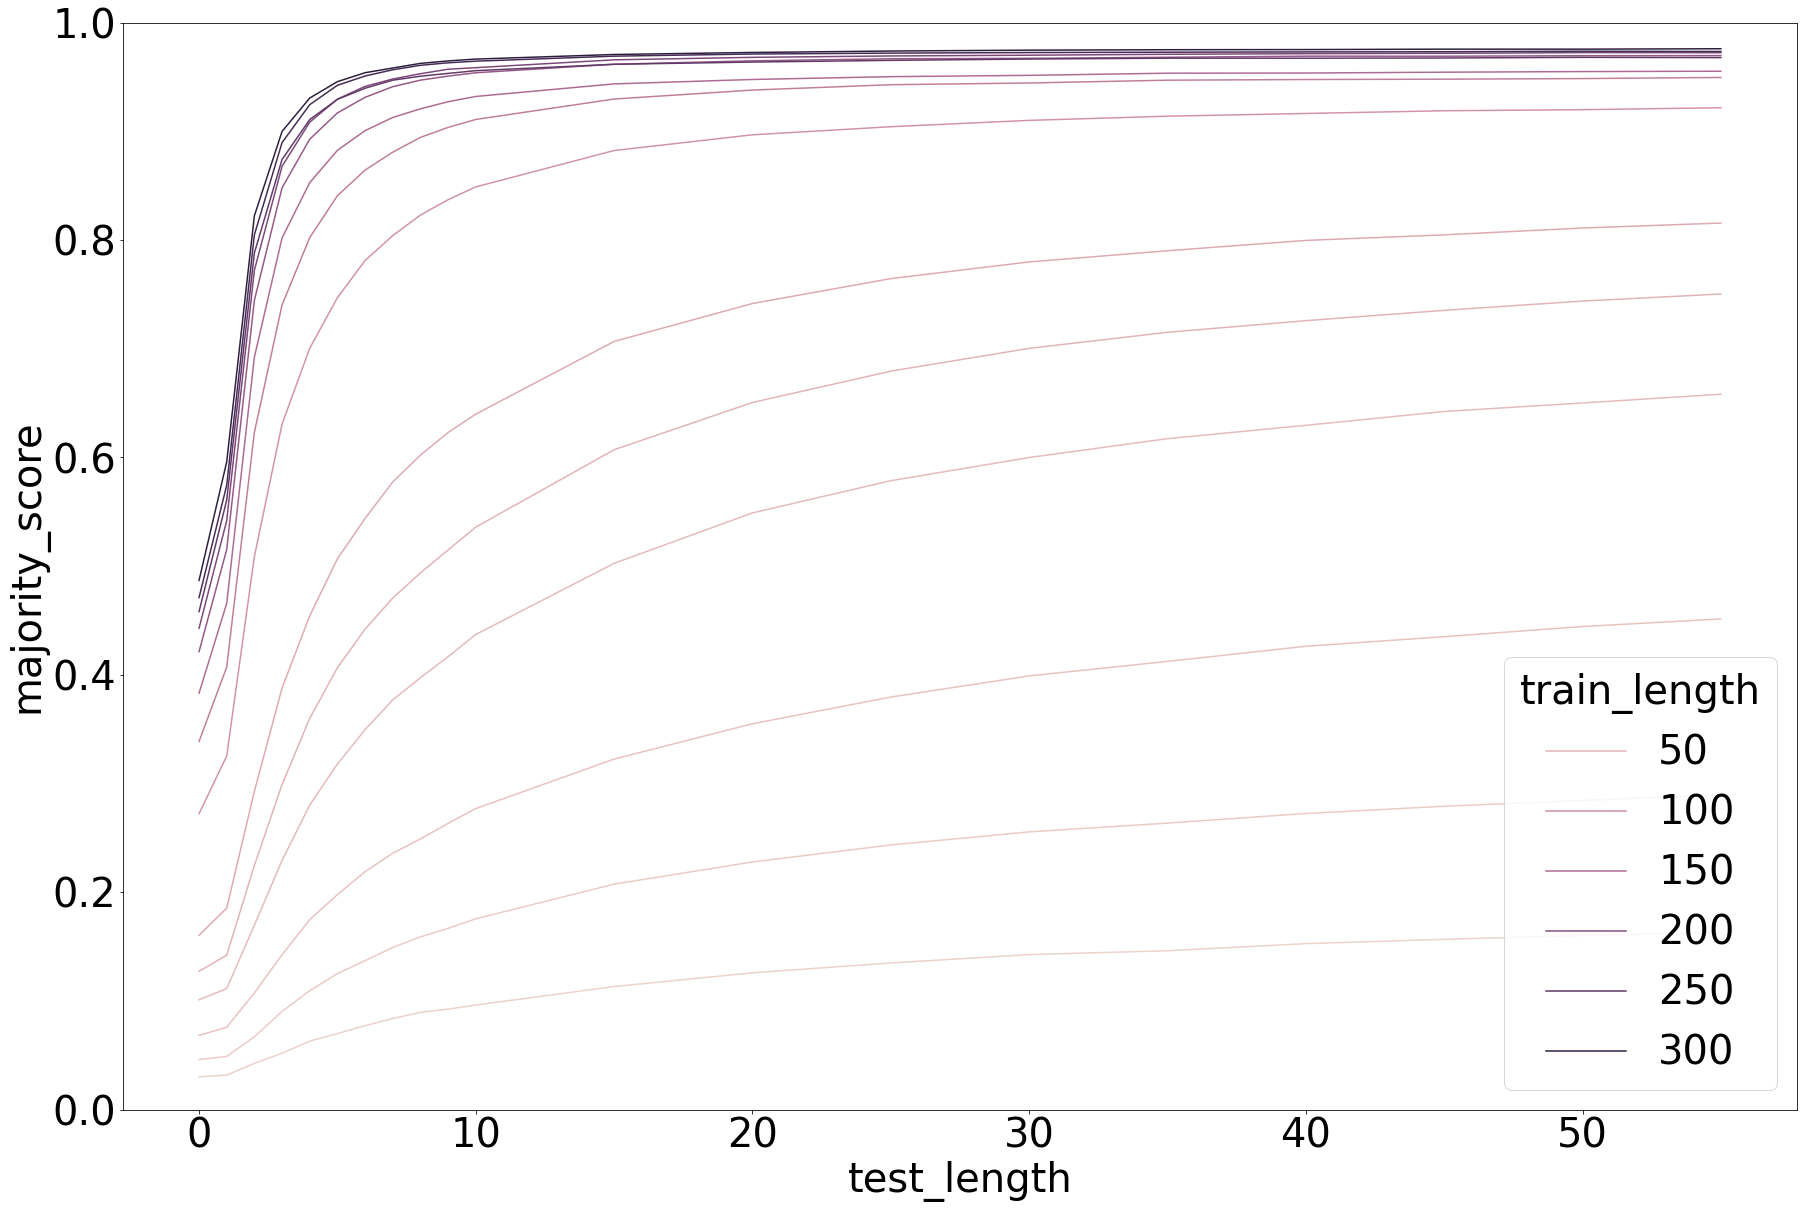

In [9]:
plt.rcParams.update({'font.size':40})
plt.figure(figsize=(30,20))
sns.lineplot(x='test_length',y='majority_score',hue='train_length',data=final_results)
plt.ylim([0,1])
plt.show()

In [10]:
final_results

,test_length,train_length,iteration,majority_score,maxmean_score
0,0,10,1,0.030436,0.030436
1,0,20,1,0.046248,0.046248
2,0,30,1,0.068437,0.068437
3,0,40,1,0.101229,0.101229
4,0,50,1,0.127357,0.127357
...,...,...,...,...,...
275,55,180,1,0.969630,0.970170
276,55,210,1,0.972322,0.973654
277,55,240,1,0.967788,0.968539
278,55,270,1,0.973423,0.974625
